### The following program implements conformal prediction on a classic loans dataset (model implemented using a 3 layer ANN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.model_selection import train_test_split #don't use for time-series baseline!
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
train_df = pd.read_csv("../../data/loan/train.csv")
test_df = pd.read_csv("../../data/loan/test.csv")

In [3]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Data pre-processing

In [4]:
def preprocess_df(dataframe, isTest=False):
    """Preprocess a dataframe, unique to the loan_prediction dataset"""
    #perform deep copy, fixes self assignment bug:
    #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    df = dataframe.copy(deep=True)
    
    null_df = np.sum(df.isnull())
    print(null_df) 
    print(f"\nTotal null values: {np.sum(null_df)}") #get total number of null values
    ### remove all rows with null values
    df = df.dropna(how='any',axis=0) 
    del df['Loan_ID'] #remove Loan_ID (irrelevant)

    # convert to binary variables

    ##----------------------------------------------------------------------------
    #### ----------------------------------Table----------------------------------
    ##----------------------------------------------------------------------------

    #> ----Gender---
    ## - Male: 0
    ## - Female: 1
    df.loc[(df.Gender == 'Male'),'Gender']=0
    df.loc[(df.Gender == 'Female'),'Gender']=1

    #> ----Married---
    ## - No: 0
    ## - Yes: 1
    df.loc[(df.Married == 'Yes'),'Married']=0
    df.loc[(df.Married == 'No'),'Married']=1

    #> ----Education---
    ## - Not Graduate: 0
    ## - Graduate: 1
    df.loc[(df.Education == 'Not Graduate'),'Education']=0
    df.loc[(df.Education == 'Graduate'),'Education']=1

    #> ----Self_Employed---
    ## - No: 0
    ## - Yes: 1
    df.loc[(df.Self_Employed == 'No'),'Self_Employed']=0
    df.loc[(df.Self_Employed == 'Yes'),'Self_Employed']=1


    #> ----Property_area---
    ## - Rural: 0
    ## - Urban: 1
    ## - Semiurban: 2
    df.loc[(df.Property_Area == 'Rural'),'Property_Area']=0
    df.loc[(df.Property_Area == 'Urban'),'Property_Area']=1
    df.loc[(df.Property_Area == 'Semiurban'),'Property_Area']=2
    
    
    #> ----Loan_Status--- (ONLY for Training set)
    ## - No: 0
    ## - Yes: 1
    if(not isTest):
        df.loc[(df.Loan_Status == 'N'),'Loan_Status']=0
        df.loc[(df.Loan_Status == 'Y'),'Loan_Status']=1

    #> -----Dependents-----
    #set max as 
    df.loc[(df.Dependents == '3+'), 'Dependents'] = 3
    ##----------------------------------------------------------------------------
    #### ----------------------------------Table----------------------------------
    ##----------------------------------------------------------------------------

    #!!! Typecase to float (for tensors below)
    df = df.astype(float)
    
    return df

In [5]:
train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df, isTest=True)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Total null values: 149
Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

Total null values: 84


In [6]:
train_df.head() #processed

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,0.0,0.0,1.0,1.0,0.0,4583.0,1508.0,128.0,360.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,3000.0,0.0,66.0,360.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,2583.0,2358.0,120.0,360.0,1.0,1.0,1.0
4,0.0,1.0,0.0,1.0,0.0,6000.0,0.0,141.0,360.0,1.0,1.0,1.0
5,0.0,0.0,2.0,1.0,1.0,5417.0,4196.0,267.0,360.0,1.0,1.0,1.0


In [7]:
test_df.head() #processed

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.0,0.0,0.0,1.0,0.0,5720.0,0.0,110.0,360.0,1.0,1.0
1,0.0,0.0,1.0,1.0,0.0,3076.0,1500.0,126.0,360.0,1.0,1.0
2,0.0,0.0,2.0,1.0,0.0,5000.0,1800.0,208.0,360.0,1.0,1.0
4,0.0,1.0,0.0,0.0,0.0,3276.0,0.0,78.0,360.0,1.0,1.0
5,0.0,0.0,0.0,0.0,1.0,2165.0,3422.0,152.0,360.0,1.0,1.0


In [8]:
# split into training and testing
X = train_df.drop('Loan_Status',axis=1).values
y = train_df['Loan_Status'].values

# X_test = test_df.values

In [9]:
print(f"Training data feature space: {X.shape}")
# print(f"Testing data feature space: {X_test.shape}")

Training data feature space: (480, 11)


In [10]:
### Create tensors from np.ndarry main data
8 #Enable cuda if available

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

## Building Model

In [11]:
#main model for loan prediction (try out different values for hidden layers to improve baseline)
class NN(nn.Module):
    def __init__(self, input_features=11, layer1=20, layer2=20, out_features=2):
        """Initialize the model for loan prediction"""
        super().__init__()
        self.fc1 = nn.Linear(input_features, layer1)
        self.fc2 = nn.Linear(layer1, layer2)
        self.out = nn.Linear(layer2, out_features)
        
    def forward(self, x):
        """Forward pass with 11 input features"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [12]:
# seed the model for reproducibility
torch.manual_seed(0)
model = NN()

In [13]:
model ##describe model, sort of (integrate tensorboard into PyTorch, not now tho)

NN(
  (fc1): Linear(in_features=11, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)

In [14]:
model = model.to(device)

In [15]:
# implement backprop
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) #adam works well for this.

In [16]:
def train(epochs=int(1e3), print_every=100, epsilon=0.5):
    """
    Train the model.
    - assumes access to following global variables: X_train, y_train, y_pred, model, loss function, & optimizer.
    @Param:
    1. epochs - number of training iterations.
    2. print_every - for visual purposes (set to None to ignore), outputs loss
    3. epsilon - threshold to break training.
    """
    start_time = time.time() #set start time
    losses = [] #plot
    
    for i in range(1, epochs+1):
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        losses.append(loss)
        
        if(loss.item() <= epsilon):
            print(f"\nCONVERGED at epoch {i} - loss : {loss.item()}")
            break #converged
        
        if(print_every is not None and i%print_every == 1):
            print(f"Epoch {i} - loss : {loss.item()}")
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("total training time (sec):", time.time()-start_time)
    return losses

In [17]:
cost = train(epochs=int(1e5), epsilon=0.2) #hopefully, it didn't overfit. :D

Epoch 1 - loss : 61.35926818847656
Epoch 101 - loss : 1.3116317987442017
Epoch 201 - loss : 0.677432119846344
Epoch 301 - loss : 0.9265301823616028
Epoch 401 - loss : 0.6723325848579407
Epoch 501 - loss : 0.6378673315048218
Epoch 601 - loss : 0.6845365166664124
Epoch 701 - loss : 0.5160427093505859
Epoch 801 - loss : 0.5029237866401672
Epoch 901 - loss : 0.49082985520362854
Epoch 1001 - loss : 0.4796518385410309
Epoch 1101 - loss : 0.4928981065750122
Epoch 1201 - loss : 0.6383454203605652
Epoch 1301 - loss : 0.4567399322986603
Epoch 1401 - loss : 0.44539836049079895
Epoch 1501 - loss : 0.44730091094970703
Epoch 1601 - loss : 0.7375766634941101
Epoch 1701 - loss : 0.4289802014827728
Epoch 1801 - loss : 0.411828875541687
Epoch 1901 - loss : 0.4025292694568634
Epoch 2001 - loss : 0.651762068271637
Epoch 2101 - loss : 0.39844778180122375
Epoch 2201 - loss : 0.3874124586582184
Epoch 2301 - loss : 0.37802672386169434
Epoch 2401 - loss : 0.9317508339881897
Epoch 2501 - loss : 0.37010416388511

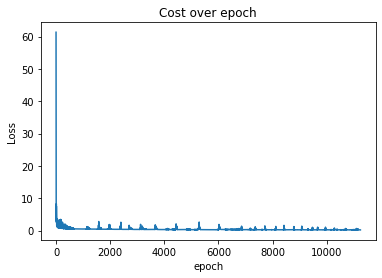

In [18]:
#graph cost
plt.plot(cost)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Cost over epoch")
plt.show()

In [19]:
def accuracy(data, verification, pprint=True):
    """Based on X_test or X_train, predict overall model accuracy."""
    predictions=[]
    with torch.no_grad():
        for i, data in enumerate(data):
            y_pred = model(data)
            predictions.append(y_pred.argmax().item())

    predictions = np.array(predictions, dtype=np.int8)
    loan = np.where(predictions == 1)[0]
    not_loan = np.where(predictions == 0)[0]
    
    if(pprint): #print logs and graph
        print(f"Prediction loans count: {len(loan)}")
        print(f"Prediction not loans count: {len(not_loan)}")
        plt.hist(loan, label='Loan')
        plt.hist(not_loan, label='Not Loan')
        plt.legend()
        plt.xlabel("Observation")
        plt.ylabel("Frequency")
        plt.title("Histogram of loan vs. not loan observations")
        plt.show()
    score = accuracy_score(verification, predictions)
    return score

Prediction loans count: 289
Prediction not loans count: 95


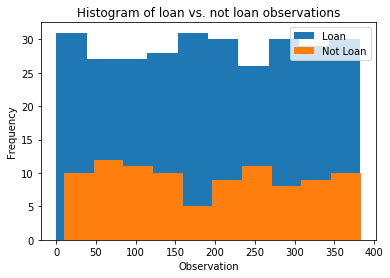

Train set accuracy: 0.917
Prediction loans count: 71
Prediction not loans count: 25


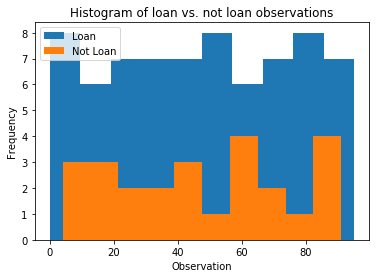

Test set accuracy: 0.75


In [20]:
print("Train set accuracy:", np.round(accuracy(X_train, y_train), 3)) #92% accuracy on test set.
print("Test set accuracy:", np.round(accuracy(X_test, y_test), 3))    #75% accuracy on test set.

## Upload models

In [21]:
#Read more: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), "../models/loan_prediction.pth")

# Conformal Prediction

<p>
Steps for conformal prediction:
<ol>
    <li>Calculate nonconformal score using Nearest Centroid algorithm</li>
    <li>Calculate p-values corresponding to the current possible prediction/label</li>
    <li>Output j as predicted label of the current example with p-value $p_j$ if and only if $p_j > \epsilon $ </li>
</ol>
</p>

### Nearest Centroid algorithm

In [22]:
def euclid(point, centroid):
    """Calculate the distance between a test point and a centroid point"""
    #assuming point and centroid are tensors
    point = np.array(point.tolist())
    centroid = np.array(centroid.tolist())
    return np.linalg.norm(point - centroid)

In [23]:
def centroid(data):
    """Find the centroid for one class of object"""
    features, observations = data.shape
    if(features > observations):
        raise ValueError("too few observations")
    
    central = []
    for i in range(features):
        mean = torch.mean(data[i])
        central.append(mean)
    return torch.FloatTensor(central).to(device)

In [24]:
def split_classes(data, labels):
    """Split data into 2 classes based on corresponding label"""
    loan, not_loan = [], []
    for i in range(data.shape[0]):
        if(labels[i].item() == 0):#no loan
            not_loan.append(data[i].tolist())
        else:
            loan.append(data[i].tolist())
    loan = torch.tensor(loan).to(device)        
    not_loan = torch.tensor(not_loan).to(device)
    return loan, not_loan

In [25]:
loan_train, not_loan_train = split_classes(X_train, y_train)
loan_test, not_loan_test = split_classes(X_test, y_test)

In [26]:
loan_centroid, not_loan_centroid = centroid(loan_train.T), centroid(not_loan_train.T)

### Non conformity score

In [27]:
def nonconformity_measure(test_point, label, loan_centroid, non_loan_centroid):
    """Computes the nonconformity score for a single test-point (HELPER method)"""
    loan_dist = euclid(test_point, loan_centroid)
    no_loan_dist = euclid(test_point, non_loan_centroid)
    if(label == 1):#loan
        return loan_dist/no_loan_dist
    else:
        return no_loan_dist/loan_dist

In [28]:
def subset_nc(testing_data, centroids):
    """Calculate the non-conformity measure for a subset of data"""
    nums = len(testing_data) #number of conformity scores
    l_c, nl_c = centroids #extract centroid into loan and not loan centroid
    y_pred = model(testing_data)
    predictions = [x.argmax().item() for x in y_pred]
    non_conformity_scores = [nonconformity_measure(testing_data[i], predictions[i], l_c, nl_c) for i in range(nums)]
    return torch.FloatTensor(non_conformity_scores).to(device)

In [29]:
def compute_p_value(data, labels, centroid, nc_scores):
    """Calculate p-value from a distribution on non-conformity scores"""
    #compute the conformity scores of dataset first (this will be the training data)
    #after this, use the conformal function to determine p-value: #{j = 1,...,n: alpha_j ≥ alpha_n}/N
    N = len(labels)
    lc, nlc = centroid
    non_conformity_scores = [nonconformity_measure(data[i], labels[i], lc, nlc) for i in range(N)]
    output = []
    for test_nc in nc_scores:
        scores = 0
        for j in range(len(non_conformity_scores)):
            if(non_conformity_scores[j] >= test_nc):
                scores += 1

        p_value = scores/N
        output.append(p_value)
        
    return torch.FloatTensor(output).to(device)

In [30]:
nc_scores = subset_nc(X_test, (loan_centroid, not_loan_centroid))

In [31]:
p_values = compute_p_value(X_train, y_train, (loan_centroid, not_loan_centroid), nc_scores)

In [32]:
def get_error(p_values, epsilon, labels, test_data):
    """Computes the error at a particular significance level(epislon) on the test data based on p-values"""
    y_pred = model(test_data)
    predictions = [x.argmax().item() for x in y_pred] #compute predictions.
    confidence = 1-p_values
    score = 0
    tots = np.size(np.where(confidence >= epsilon))
    for prediction, label, conf in zip(predictions, labels, confidence):
        if(prediction == label and conf >= epsilon):
            score += 1/tots

#     print(f"{epsilon*100}% confidence yields {np.round(score*100,3)}% accuracy")
    return score*100, tots

In [33]:
error = []
samples = []
for i in range(0, 100):
    score, tots = get_error(p_values, i/100, y_test, X_test)
    error.append(score)
    samples.append(tots)

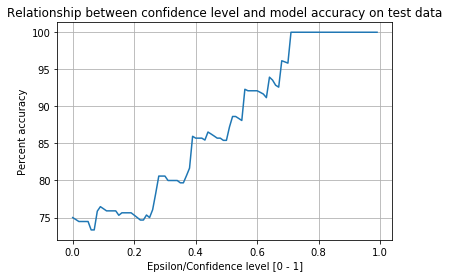

In [34]:
plt.plot(np.arange(0, 100)/100, error)
plt.xlabel("Epsilon/Confidence level [0 - 1]")
plt.ylabel("Percent accuracy")
plt.title("Relationship between confidence level and model accuracy on test data")
plt.grid()
plt.show()

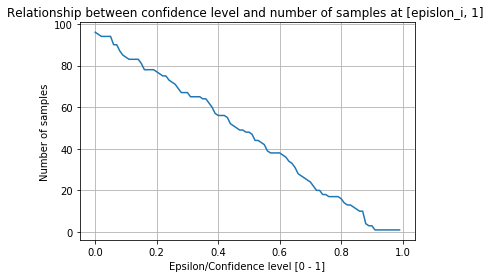

In [35]:
plt.plot(np.arange(0, 100)/100, samples)
plt.xlabel("Epsilon/Confidence level [0 - 1]")
plt.ylabel("Number of samples")
plt.title("Relationship between confidence level and number of samples at [epislon_i, 1] ")
plt.grid()
plt.show()